<a href="https://colab.research.google.com/github/park-hoyeon/park-hoyeon.github.io/blob/master/skt_7_05_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Transformer 실습자료**
Google colab 환경에 맞게 최적화

Follwing codes @[bentrevett](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb)



[Attention is all you need](https://arxiv.org/abs/1706.03762) 논문의 Transformer 구현

- 현재까지도 대부분의 많은 SOTA 모델들이 트랜스포머 기반임
- 본 Transformer의 변형 중 하나이자 현재까지도 가장 인기있는 모델은 [BERT](https://arxiv.org/abs/1810.04805)(**B**idirectional **E**ncoder **R**epresentations from **T**ransformers)임

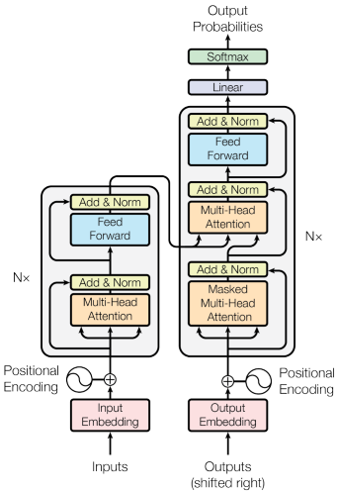

여기서 우리가 주된 목표로 볼 것은 **모델의 전체 구조**

## 기초 라이브러리 함수 호출 및 데이터 준비

In [ ]:
pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import spacy, random, math, time

### 동일한 결과 출력을 위한 랜덤시드 고정

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 독일어와 영어 데이터셋 다운로드 & 로드

In [ ]:
import spacy.cli
spacy.cli.download("de_core_news_sm")
spacy.cli.download("en_core_web_sm")

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 전처리



###각 언어의 단어 토큰화

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

데이터가 배치 차원으로 공급될 것을 예상하여 batch_first = True로 사용

In [ ]:
SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

In [ ]:
# https://github.com/multi30k/dataset
!wget -q https://github.com/multi30k/dataset/raw/master/data/task1/raw/train.de.gz
!wget -q https://github.com/multi30k/dataset/raw/master/data/task1/raw/train.en.gz
!wget -q https://github.com/multi30k/dataset/raw/master/data/task1/raw/val.de.gz
!wget -q https://github.com/multi30k/dataset/raw/master/data/task1/raw/val.en.gz
!wget -q -O test2016.de.gz https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2016_flickr.de.gz
!wget -q -O test2016.en.gz https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2016_flickr.en.gz

In [ ]:
!mkdir multi30k; mv *.gz multi30k
!cd multi30k; gunzip *.gz

mkdir: cannot create directory ‘multi30k’: File exists


In [ ]:
train_data, valid_data, test_data = Multi30k.splits(
    root=".", # ./multi30k
    exts = ('.de', '.en'),
    fields = (SRC, TRG))

In [ ]:
#train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
#                                                    fields = (SRC, TRG))

### Vocabulary 생성

TorchText는 자동으로 vocab을 생성해줍니다.

- 최소 2번 미만으로 나타나는 모든 토큰을 변환시켜 어휘 생성
- GPU 를 사용할 경우, device 를 GPU 로 세팅

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

### 배치 별 반복을 위한 Iterator 세팅

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
     batch_size = BATCH_SIZE,
     device = device)

- 이전 모델들과 동일하게 인코더, 디코더로 구성
- 인코더: input sentence를 컨텍스트 벡터로 인코딩
- 디코더: 인코딩된 컨텍스트 벡터를 디코딩하여 output으로 영어를 출력

## Positional Encoding

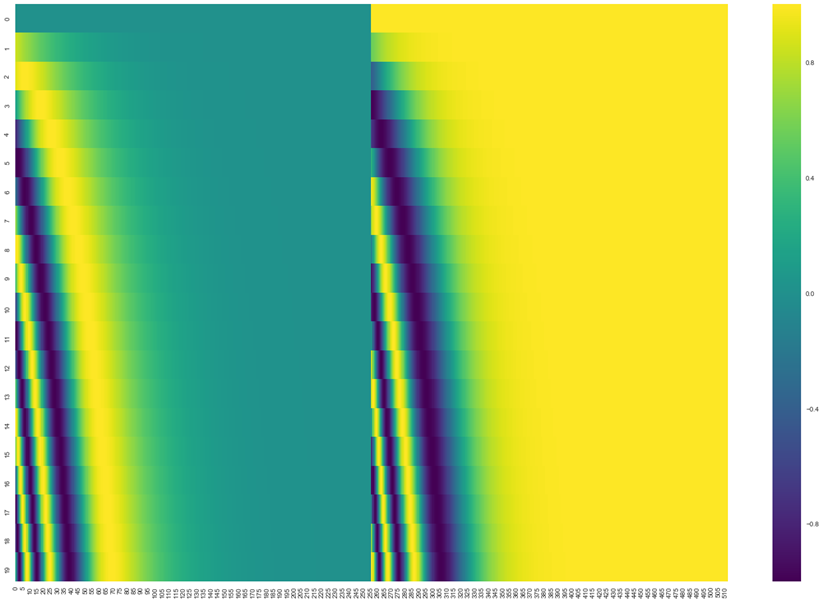

- 위치 pos, 임베딩 차원 i 에서의

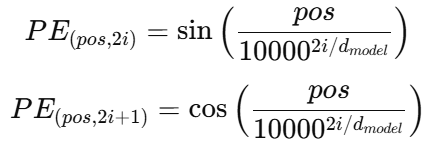

- 각 위치마다 임베딩 차원에 대해 주기적인 값을 가진 sin or cos 함수 적용
- 이로써 토큰의 위치에 따라 고유한 위치 벡터 생성
- 임베딩 차원 별 **다양한 주기를 갖는 파형**으로 위치 구분

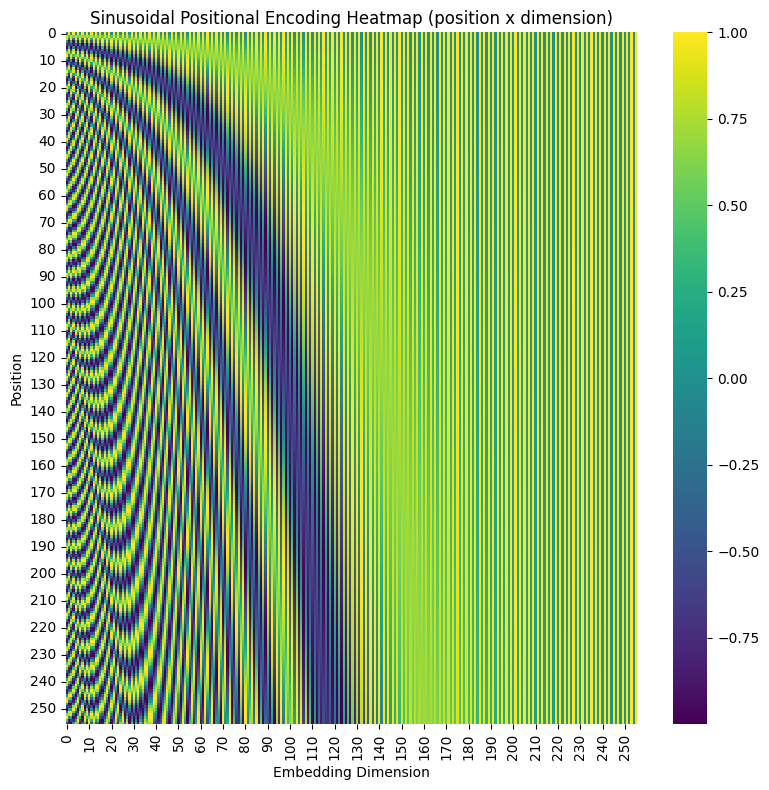

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

d_model = 256      # emb_dim #해당 값을 변경하여 수행
max_len = 256       # max_len

# Positional Encoding
PE = np.zeros((max_len, d_model))
position = np.arange(0, max_len)[:, np.newaxis]  # shape: (max_len, 1)
div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))  # shape: (d_model/2,)

# i/2 == sin, i/2+1 == cos
PE[:, 0::2] = np.sin(position * div_term)
PE[:, 1::2] = np.cos(position * div_term)

# Transpose for heatmap (dimension x position)
PE_T = PE.T

# heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(PE, cmap='viridis', xticklabels=10, yticklabels=10)
plt.title("Sinusoidal Positional Encoding Heatmap (position x dimension)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position")
plt.tight_layout()
plt.show()

## Transformer 모델 설계 - 인코더



인코더는 아래 그림에서 왼쪽에 해당

앞서 배운대로,

트랜스포머는 순차적으로 입력 받는 방식이 아니므로, 이를 위한 **positional encoding**을 사용하여 순서 정보를 고려한 임베딩 벡터 생성
- 이는 첫 토큰인 0번째 위치의 <sos> 토큰으로 시작하는 임베딩
- vocab의 크기는 100으로, 이는 모델이 최대 100개의 토큰 길이의 문장을 받아들일 수 있음을 의미
- 더 긴 문장 처리를 위해서는 이를 늘릴 수 있음

- 다음으로, 토큰과 positional embeddings를 elementwise sum (각 요소 별 합산) 하여 토큰에 대한 정보와 문장의 위치를 포함하는 벡터를 얻음
- 여기서 차원은 hidden dimension size를 의미
- 모델의 안정적 학습을 위해 dropout을 적용
- 이후 결합된 임베딩은 N개의 encoder layer를 통과하여 얻은 벡터를 디코더에서 사용

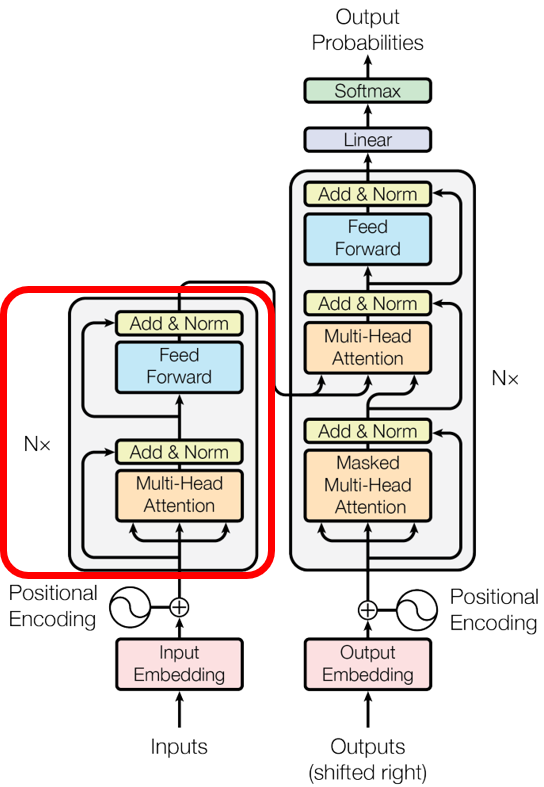

src_mask: 입력 데이터의 마스킹된 데이터로, pad가 아닌 경우 1, pad 토큰인 경우 0

- pad 토큰의 경우 attention X

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src

### Encoder layer

인코더 계층(Encoder layer)은 인코더의 모든 임베딩 결과가 만나는 곳임. 이 과정에서,

1. 마스킹된 source sentence 정보를 multi-head attention 레이어에 전달 및 dropout 수행
 - multi-head attention 레이어는 source sentence 에 집중하기 위함
2. residual connection을 적용하여 layer normalization 계층 수행
3. 이후 feedforward를 통과한 다음 dropout, 그리고 residual connection을 적용하여 layer normalization 계층 반복 수행

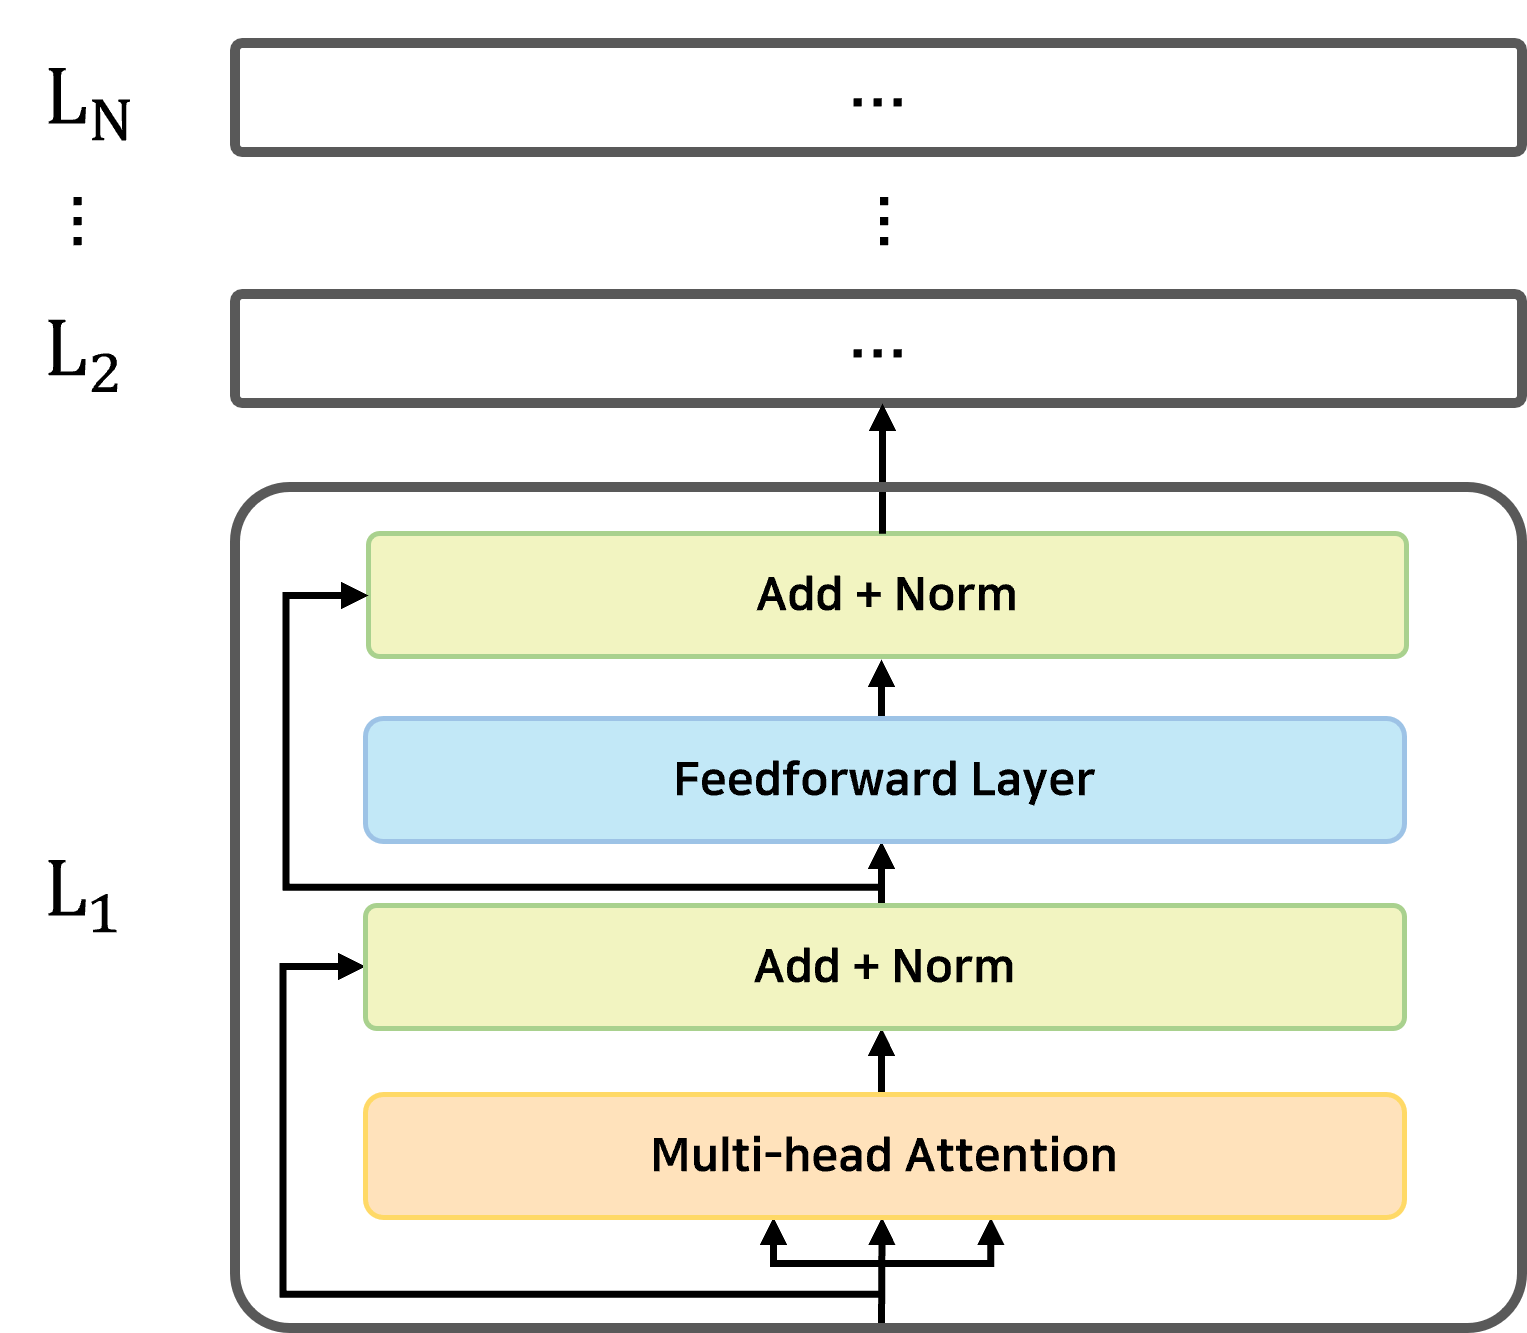

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

### Multi-head Attention layer

- 인코더의 입력 벡터(각 단어의 임베딩)에서 3개의 벡터(Q, K, V)를 생성

- 이러한 벡터는 임베딩에서 학습된 3개의 행렬을 곱하여 생성됨

연산 순서(아래 그림 참고)

*  Q, K의 dor-product(내적) 연산 후 softmax, 이후 $d_k$스케일링, (여기서 $d_k$는 헤드의 차원을 의미)
*  위 연산 결과 * V 연산으로 결합

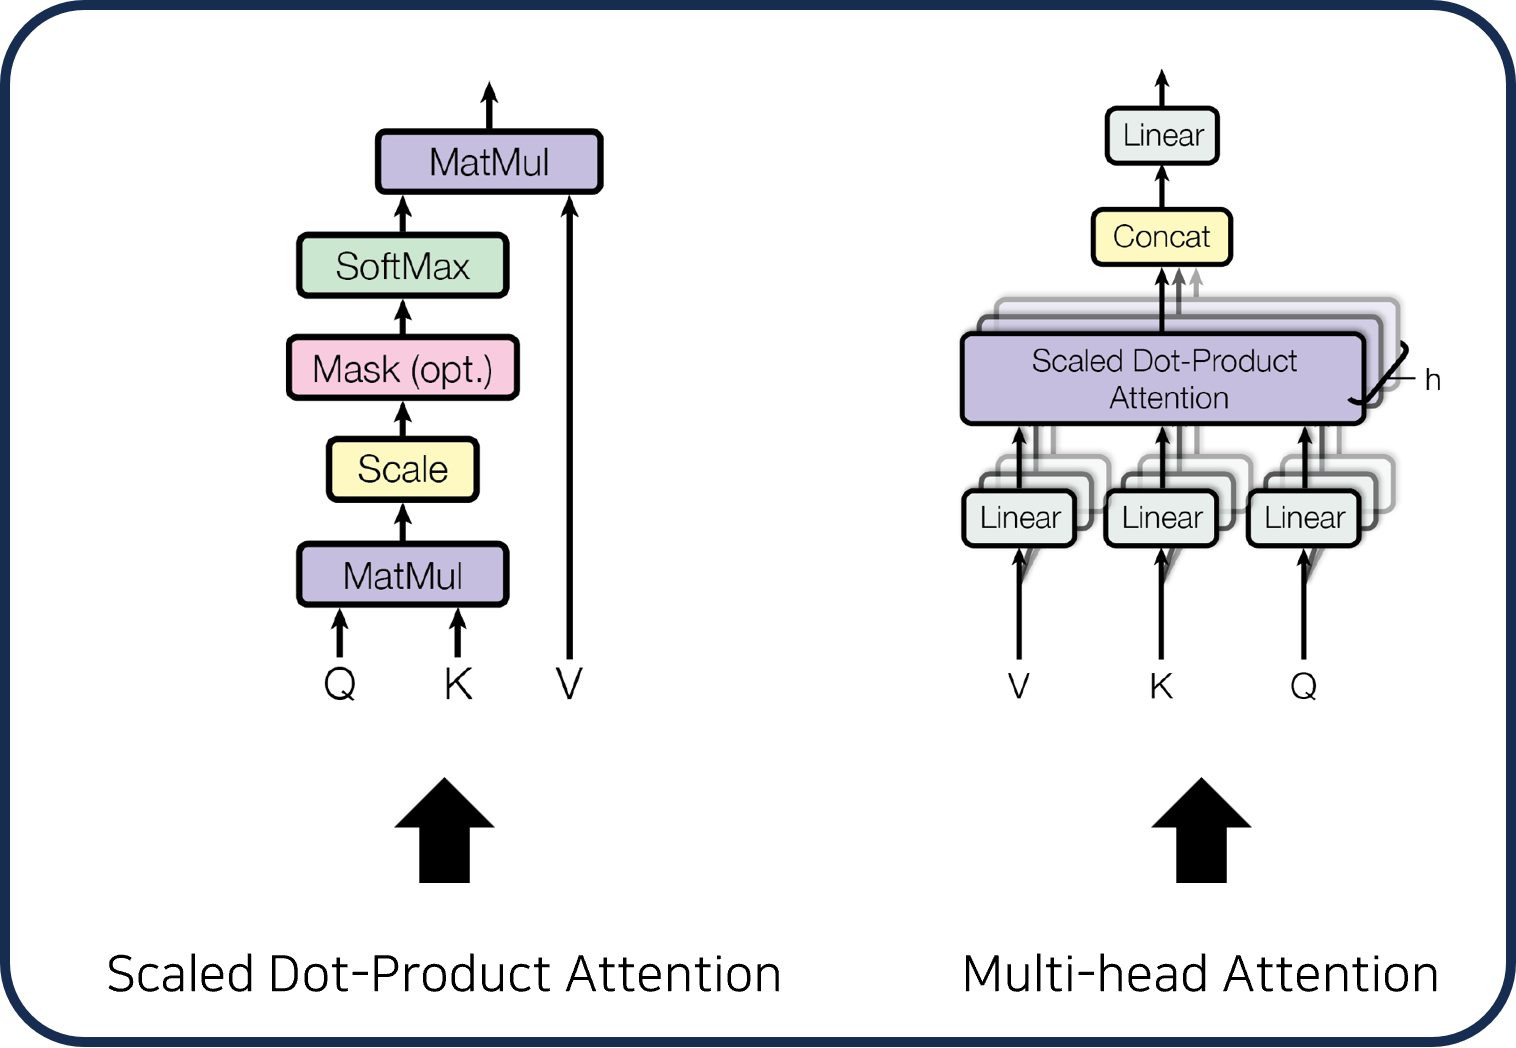

- 여기서, h 개의 헤드로 분할하여 scaled dot-product 연산은 모든 head에서 병렬로 계산
- 위 그림 우측의 $h$가 아래 그림에서의 각 $Z_n$ 임(여기서는 8개의 head 즉, hid_dim 512 / 8 = 각 64차원으로 표현)

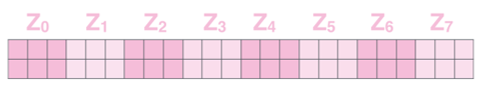

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

### Position-wise Feedforward Layer

인코더 계층 내부의 주요 블록인 position-wise feedforaward layer 구현

- 여기서 입력은 hid_dim -> pf_dim 으로 변환
- 다시 hid_dim 으로 변환되기 전에, ReLU 활성화함수 및 dropout 적용

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

## ## Transformer 모델 설계 - 디코더

디코더 역할:


 - source sentence Z의 인코딩된 표현(encoded representation)을 가져와 target sentence $Y'$의 예측된 토큰 으로 변환하는 것

 (그러면, 예측된 $Y'$ 과 실제 정답값인 $Y$ 비교를 통해 loss 계산 및 예측 성능을 끌어올리기 위해 모델 업데이트를 통한 파라미터 학습)


 - 인코더와 유사하지만, 2개의 multi-head attention 존재(아래 그림)

* 1. target sequence에 대한 masked multi-head attention layer
* 2. decoder representation을 쿼리로 사용하고 encoder representation을 K, V로 사용하는 multi-head attention layer

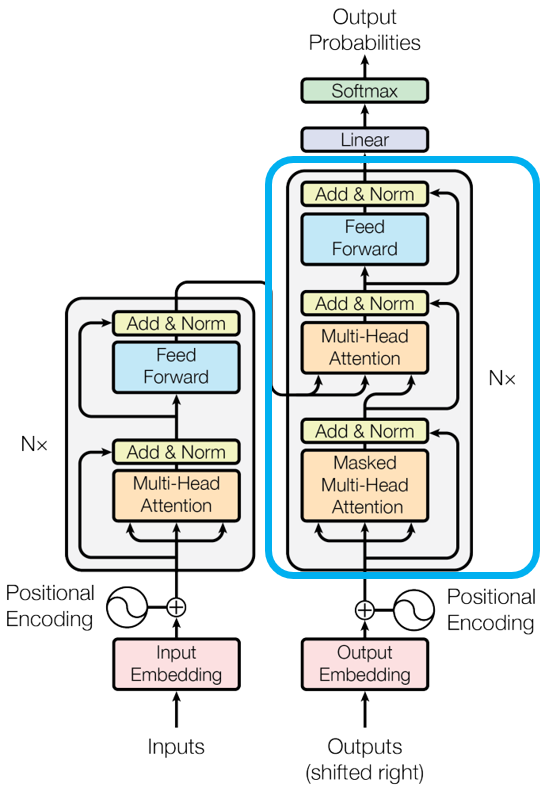

자세한 내용은 아래 소스 참고

- 결합시킨 임베딩은 인코딩 정보인 enc_src 와 target masks와 함께 N 개의 디코더 계층 통과
- N 개의 계층 통과 다음, decoder representation은 linear layer(fc_out)를 통과함

- 디코더 또한, <pad>에 attention 되지 않도록 mask를 사용

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

### 디코더의 예측 방식

- Transformer 구조상 모든 target 토큰을 한 번에 병렬 처리하므로, target sequence의 다음 토큰이 무엇인지 구조적으로 알 수 있으므로, 값을 미리 알 수 없도록 'Cheating'하는 target mask 사용(아래 그림 예시)


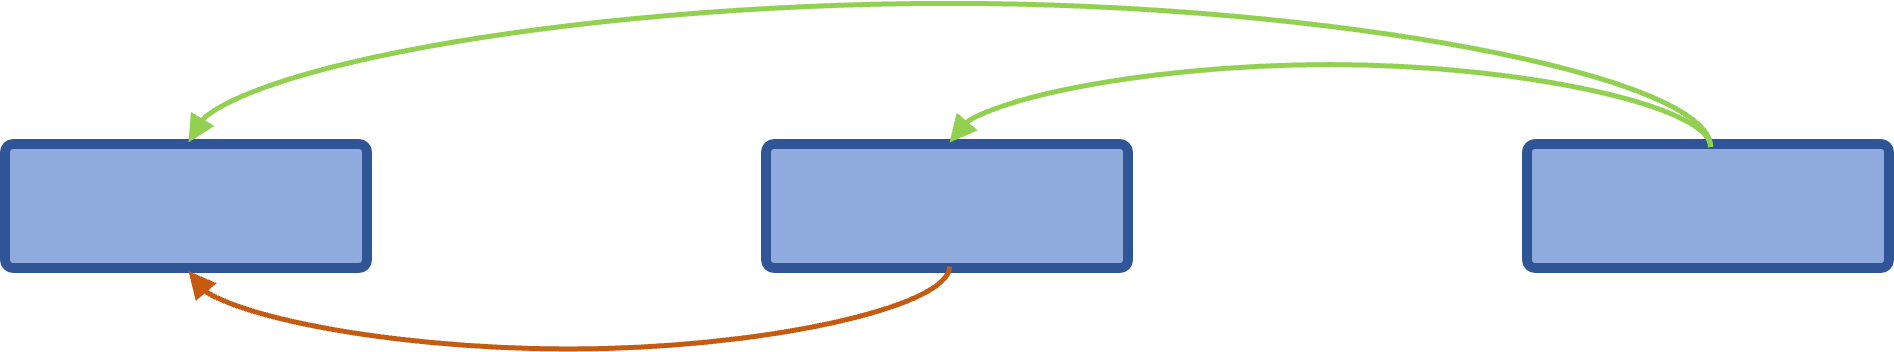

### Decoder layer

- 인코더와 유사하게 self-attention 을 수행하며, 'cheating' 방지를 위해 sequence mask인 trg_mask를 사용

- encoded source sentence 인 enc_src를 디코더에 실제로 공급하는 방법
* Q: decoder representation
* K, V: encoder representation

- 이후 <pad> 토큰 추가하여 집중하고자 하는 토큰에만 집중 및 dropout, residual connection과 layer normalization 계층 수행

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

## Transformer-Seq2Seq(인코더-디코더)

인코더와 디코더 각각의 캡슐화

**[인코더]**
- 토큰의 <pad> 여부를 따져서 <pad> 토큰이 아닌 경우 1, 맞을 경우 0
- Shape: [batch size, n heads, seq len, seq len]

**[디코더]**
- 인코더와 동일하게 <pad> 마스크 생성
- torch.tril 사용하여 subsequent 마스크 trg_sub_mask 생성
-- 이를 통해 대각선 기준 위의 요소는 0이 되고 아래의 요소는 입력 텐서로 1로 채워진 텐서

(예시)

10000

11000

11100

11110

11111


source & target sentence 가 마스킹된 후,

인코더 source sequence 에 대한 디코더의 attention과 함께, 예측된 target 문장 (output)을 획득

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## Transformer 모델 학습

Seq2Seq의 Encoder-Decoder 초기화 및 모델 학습 수행

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1

DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

NameError: name 'SRC' is not defined

Encoder, Decoder를 포함한 Seq2Seq으로 캡슐화하여 정의

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

NameError: name 'SRC' is not defined

파라미터 계산

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


파라미터 초기화를 위해 xavier uniform 사용(대중적인 방법 중 하나 선택)

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

하이퍼파라미터 세팅 및 <pad> 토큰에 대해 계산되는 loss 무시하도록 정의

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

모델 학습을 위한 train 함수 정의

In [ ]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

모델 평가 함수 정의(graident, parameter 업데이트 제외)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

Epoch 별 시간 체크

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

###모델 학습 및 파라미터 저장

환경에 따라 모델 학습에 시간이 다소 걸릴 수 있습니다

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

NameError: name 'time' is not defined

최적의 파라미터가 저장된 'transformer-model.pt'를 호출하여 evaluate에 입력

test셋에 모델 성능 평가

In [ ]:
model.load_state_dict(torch.load('transformer-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

NameError: name 'model' is not defined

## Inference(추론 = 학습된 모델 테스트)

우리가 학습한 모델을 가지고 실제 어떻게 적용하는지 알아보기 위함

순서는 아래와 같음

1. 입력 문장의 토큰화
2. 시작과 끝을 알리는 <sos>, <eos> 토큰 추가
3. 입력 문장 수치화
4. 텐서 변환 및 배치 dim 추가
5. source 문장 생성
6. 마스킹된 source 문장을 인코더에 feed
7. <sos> 토큰으로 초기화된 output 문장을 저장할 list 생성

=====디코더 과정에서는 아래와 같은 과정 반복 수행=====

7-1. 현재 output 의 예측을 배치 차원의 텐서로 변환

7-2. target sentence mask 생성

7-3. 마스킹된 현재의 output과 인코더 output 모두 디코더에 feed

7-4. attention과 함께 다음 output 예측 수행

7-5. 예측이 <eos>인 경우 중단

- 이후, 출력 문장을 인덱스(index) 값에서 token으로 변환
- <sos> 토큰을 제거하고 최종 output sentence 를 반환

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:,-1].item()

        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

다음의 display_attention은 입력 source 문장에 대해 각 8개의 헤드의 attention 을 시각화 하기위한 함수임

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(15,25))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

training 데이터를 예제 데이터로 활용해보기

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

NameError: name 'train_data' is not defined

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

NameError: name 'src' is not defined

- 번역 결과가 비교적 괜찮으나, walking -> walks 로 변함 (의미 변화는 없음)

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


### Head 별 결과 시각화

각 헤드가 실제로 집중(attention) 하고 있는 것이 무엇인지 알 수 있음

- 어떤 head는 'a' 번역 시 'eine'에 완벽히 attention 함(반대로 그렇지 않은 경우도 있음)
- 일반적으로 대각선(좌 상단->우 하단) 패턴을 따르며, 마지막 두 토큰 출력 시 attention이 두 토큰에 균등하게 분산되는 것을 보임

<ipython-input-33-d4ec6c2376b9>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-33-d4ec6c2376b9>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


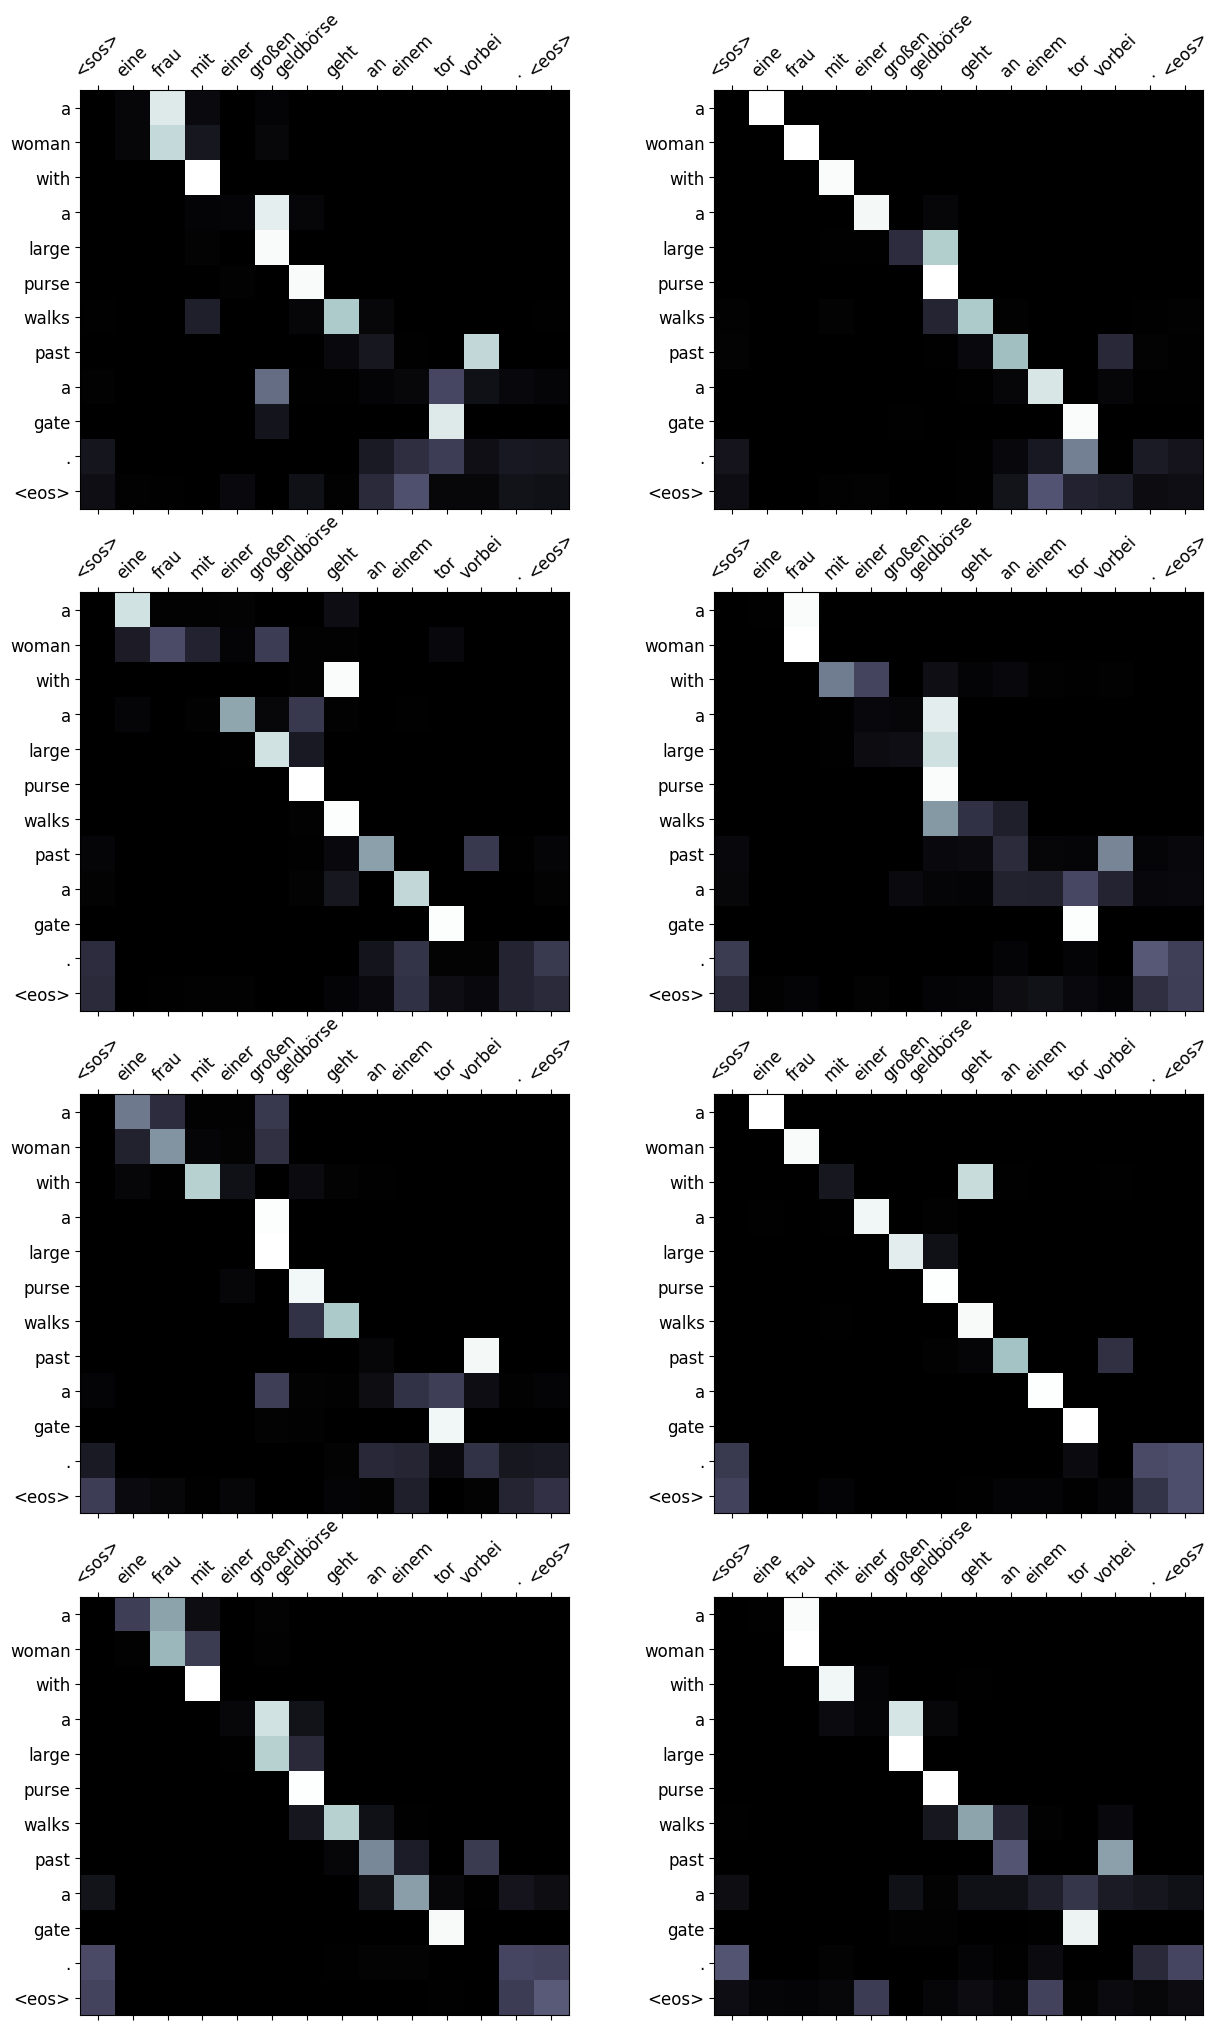

In [ ]:
display_attention(src, translation, attention)

### Valid, Test 셋에서도 동일하게 수행해보기

In [ ]:
# Valid, Test 셋에서 동일하게 출력 및 결과 확인하기



# BLEU score 를 통해 모델의 정량적 평가 수행

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 34.79


학습 환경에 따라 BLEU score는 다소 차이(1~2)가 있을 수 있음